In [13]:
%matplotlib inline

import random

import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
from scipy import stats
from scipy.stats import randint, uniform
from sklearn import linear_model, preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              RandomForestClassifier, RandomForestRegressor)
from sklearn.linear_model import Lasso, LogisticRegression, Ridge
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_absolute_error, r2_score)
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split)
from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, OneHotEncoder,
                                   PolynomialFeatures, RobustScaler,
                                   StandardScaler)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV

pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)

In [14]:
target = 'Sph-Far-R'
prefAmountRecords = 3

# import data
dataset_og = pd.read_csv(f'Data\Measurements-Transformed')
dataset_ogs = pd.read_csv(f'Data\Measurements-Sliding-Window-{prefAmountRecords}')
# kopie maken indien we iets van de originele data nodig hebben
dataset = dataset_ogs.copy()
dataset.shape

(4998, 44)

### spaghetti tijd

kijken wa voor trends we allemaal hebben per persoon  
die dan uniform maken (trend spiegelen of omdraaien en shit)  
om dan iets algemener uit te halen  
clustering + lreg + rfr + whatever

In [4]:
dataset_hl_s = pd.DataFrame() # high - low
dataset_lh_s = pd.DataFrame() # low - high
dataset_nc_s = pd.DataFrame() # no change
hl, lh, nc = 0, 0, 0
for index, row in dataset.iterrows():
    if row[f'{target}_0'] > row[f'{target}_{prefAmountRecords-1}']:
        dataset_hl_s = dataset_hl_s.append(row) 
        hl+=1
    elif row[f'{target}_0'] < row[f'{target}_{prefAmountRecords-1}']:
        dataset_lh_s = dataset_lh_s.append(row) 
        lh+=1
    elif row[f'{target}_0'] == row[f'{target}_{prefAmountRecords-1}']:
        dataset_nc_s = dataset_nc_s.append(row) 
        nc+=1
print(f'High to low: {hl} \nLow to high: {lh} \nNo Change: {nc}')

High to low: 2236 
Low to high: 1621 
No Change: 1139


In [ ]:
fig, axs = plt.subplots(nrows= 3, ncols= 3, figsize=(15, 15))
fig.suptitle('Verbanden met leeftijd (in dagen) per richting van oogversclechtering')
for i, df in enumerate([dataset_hl, dataset_lh, dataset_nc]):
    for ii in range(prefAmountRecords):
        sns.scatterplot(x = f'Measurement_Age_{ii}', y = f'{target}_{ii}', data = df, ax=axs[i, ii])
        axs[i, ii].set(xlabel=None, ylim=(-15,15))
plt.show()

In [37]:
dataset_og.sort_values('ID')

dataset_hl = pd.DataFrame() # high - low
dataset_lh = pd.DataFrame() # low - high
dataset_nc = pd.DataFrame() # no change
hl, lh, nc = 0, 0, 0
for index, row in dataset.iterrows():
    if row[f'{target}_0'] > row[f'{target}_{prefAmountRecords-1}']:
        dataset_hl = dataset_hl.append(dataset_og.loc[dataset_og['ID'] == row[0]]) 
        hl+=1
    elif row[f'{target}_0'] < row[f'{target}_{prefAmountRecords-1}']:
        dataset_lh = dataset_lh.append(dataset_og.loc[dataset_og['ID'] == row[0]]) 
        lh+=1
    elif row[f'{target}_0'] == row[f'{target}_{prefAmountRecords-1}']:
        dataset_nc = dataset_nc.append(dataset_og.loc[dataset_og['ID'] == row[0]]) 
        nc+=1
        # print(np.abs(row[f'{target}_0']) - np.abs(row[f'{target}_{prefAmountRecords-1}']))
print(f'High to low: {hl} \nLow to high: {lh} \nNo Change: {nc}')

High to low: 2236 
Low to high: 1621 
No Change: 1139


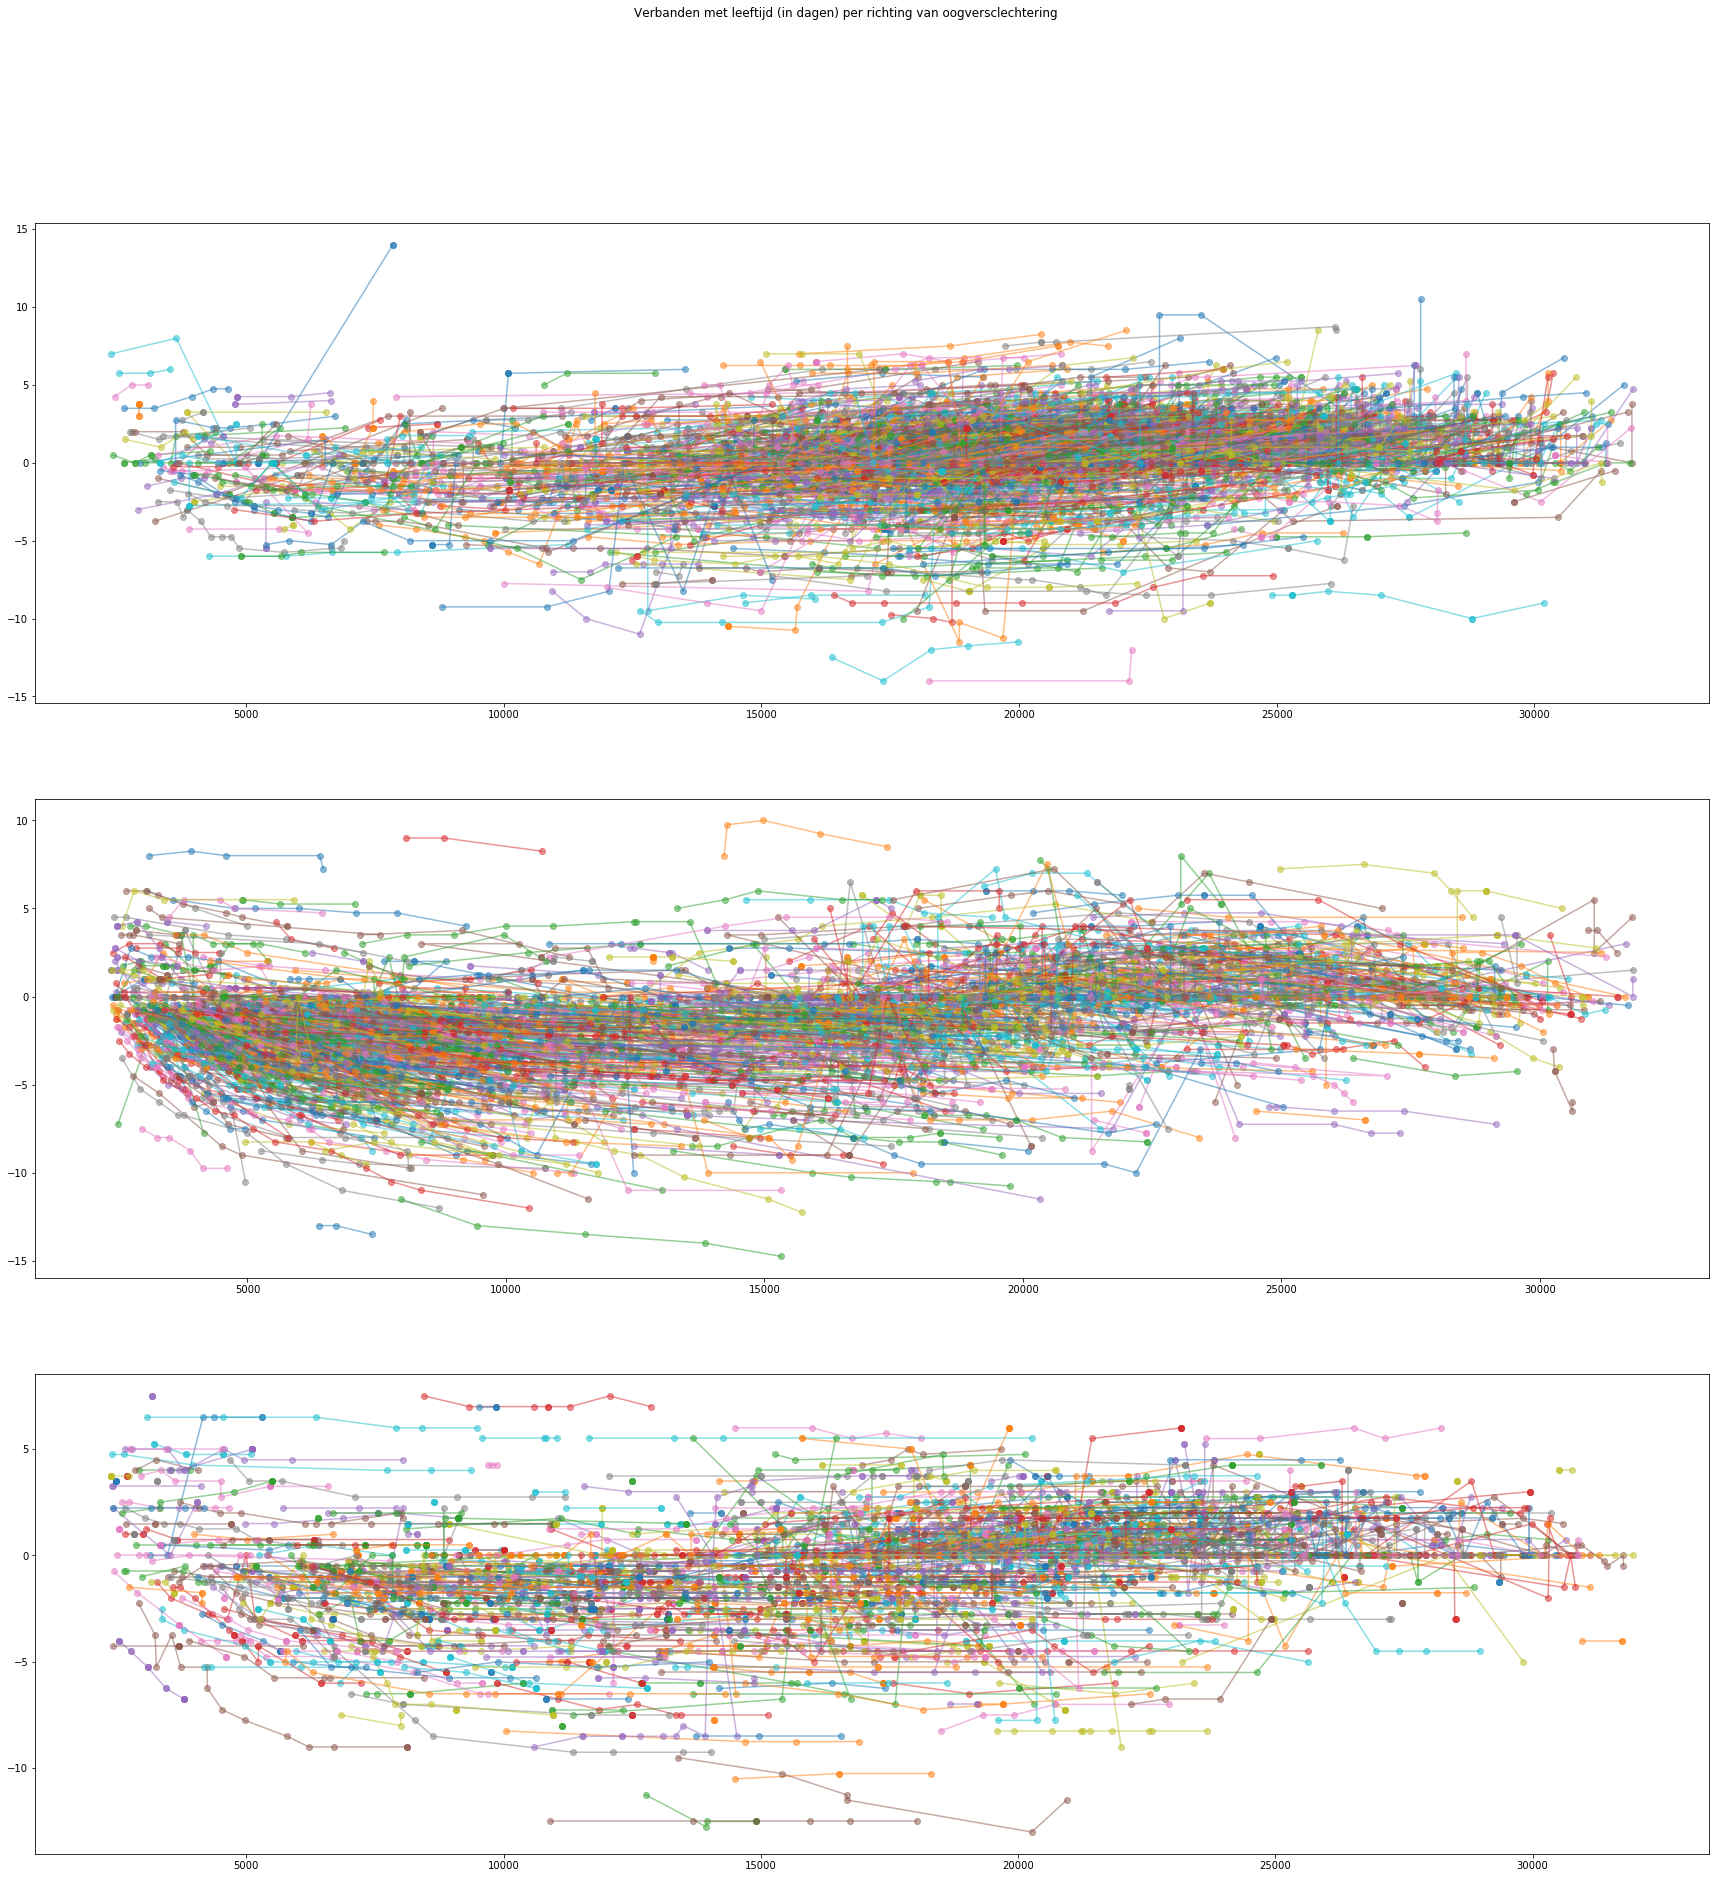

In [38]:
fig, axs = plt.subplots( nrows = 3, figsize=(30, 30))
fig.suptitle('Verbanden met leeftijd (in dagen) per richting van oogversclechtering')

for i, df in enumerate([dataset_hl, dataset_lh, dataset_nc]):
    for key,grp in df.groupby('ID'):
        if len(df.groupby('ID')) >= prefAmountRecords:
            axs[i].plot(grp['Measurement_Age'], grp[target],'o-',label = key, alpha=0.5)
